In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('../src_jobs/')

In [2]:
import pickle
from itertools import repeat
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from artifact import Saw
from sliding_window_detector import SlidingWindowTransformerDetector, ConvolutionalSlidingWindowDetector, SlidingWindowLinearDetector
from mask_detector import WindowLinearDetector, WindowTransformerDetector, ConvolutionDetector

from data import RealisticArtifactDataset, CachedArtifactDataset, TestArtifactDataset, CenteredArtifactDataset

/opt/miniconda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.set_grad_enabled(False)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [4]:
test_width = 512

test_path = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/test_label_CinCECGTorso512.pkl")
test = CachedArtifactDataset(file=test_path)

val_path = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/val_SW_noCiECGT512.pkl")
val = CachedArtifactDataset(file=val_path)

In [4]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

#autheticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient.from_config(
    credential=credential,
    path="config.json",
)

Found the config file in: config.json


In [8]:
import azure.ai.ml._artifacts._artifact_utilities as artifact_utils

data_asset_model = ml_client.data.get("output_Train_SW_ftFrancois_FCNTrans_LRsmall_FP02_valF", version="1")
artifact_utils.download_artifact_from_aml_uri(uri=data_asset_model.path, destination="./checkpoints_transformer/", datastore_operation=ml_client.datastores)
# paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/notebooks/checkpoints_transformer/WindowLinearDetector_mask_639.28K_28-05-2024_07:50:53/epoch=0-step=15500.ckpt" # Mask CNN Trans
# mask_CNNTrans_detector = WindowTransformerDetector.load_from_checkpoint(paths_mask).cpu()

'./checkpoints_transformer/'

In [6]:
paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_FCN.ckpt" # SW FCN
SW_FCN_detector = ConvolutionalSlidingWindowDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_adaFCN.ckpt" # SW adapted FCN
SW_adaFCN_detector = ConvolutionalSlidingWindowDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_TransOnly_GAPLin.ckpt" # SW Transformer only GAP Lin
SW_TransOnly_GAPLin_detector = SlidingWindowTransformerDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_TransOnly_GAP.ckpt" # SW Transformer only totalGAP
SW_TransOnly_GAP_detector = SlidingWindowTransformerDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_CNN_Dense.ckpt" # SW 1d CNN Dense
SW_CNNDense_detector = SlidingWindowLinearDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_adaFCN_Dense.ckpt" # SW ada 1d CNN Dense
SW_adaCNNDense_detector = SlidingWindowLinearDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_CNN_Trans.ckpt" # SW 1d CNN Transformer
SW_CNNTrans_detector = SlidingWindowTransformerDetector.load_from_checkpoint(paths_SW).cpu()

paths_SW = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/SW_adaFCN_Trans.ckpt" # SW ada 1d CNN Transformer
SW_adaCNNTrans_detector = SlidingWindowTransformerDetector.load_from_checkpoint(paths_SW).cpu()

SW_detectors = [SW_FCN_detector.eval(), SW_adaFCN_detector.eval(), SW_TransOnly_GAPLin_detector.eval(), SW_TransOnly_GAP_detector.eval(), SW_CNNDense_detector.eval(), SW_adaCNNDense_detector.eval(), SW_CNNTrans_detector.eval(), SW_adaCNNTrans_detector.eval()]

/opt/miniconda/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'act_fct' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fct'])`.
  rank_zero_warn(


In [59]:
def baseline_detector(input: torch.Tensor) -> int:   
    input.squeeze(0)
    prediction = 0

    center = int(input.shape[1]/2)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[0][1:] - input[0][:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)

    if increments[center-1] > (mean_increment + 3*std_increment):
        prediction = 1
    
    return prediction

## Predictions on Validation set for threshold calculation with fbeta score

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

all_predictions_valSet = pd.DataFrame(columns=['Detector_id', 'predictions'])
index = 0
gt = list()

for detector in SW_detectors:

    preds = list()

    for sample in val:
        example = sample["data"]
        window  = detector.window
        length  = len(example)

        # add artifact to data
        example_data = torch.tensor(example + sample["artifact"])

        # set detector to evaluation mode
        detector.eval()
        # make prediction and insert into prediction
        prediction = detector(example_data.unsqueeze(0))

        # update count
        preds = preds + [prediction.numpy()]

        if index == 0 :
            gt = gt + [sample["label"]]
    

    new_row = pd.DataFrame([{
        'Detector_id': index +1,
        'predictions': preds
    }])

    all_predictions_valSet = pd.concat([all_predictions_valSet,new_row])
    index = index +1
    print(len(all_predictions_valSet))

all_predictions_valSet = pd.concat([
    all_predictions_valSet,
    pd.DataFrame([{
        'Detector_id': 0,
        'predictions': gt
    }])
    ])


/opt/miniconda/lib/python3.10/site-packages/torch/nn/modules/conv.py:303: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv1d(input, weight, bias, self.stride,


1


KeyboardInterrupt: 

In [9]:
from sklearn.metrics import fbeta_score

gt = all_predictions_valSet.iloc[-1]["predictions"]
metrics = pd.DataFrame()
for index, row in all_predictions_valSet.iterrows():

    max_fbeta = 0

    for threshold in np.linspace(0,  1,  100):
        predictions = np.where(np.array(row['predictions']) > threshold, 1, 0)

        fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

        if (fbeta > max_fbeta):
            max_fbeta = fbeta
            best_threshold_fbeta = threshold

    predictions = np.where(np.array(row['predictions']) > best_threshold_fbeta, 1, 0)

    tn, fp, fn, tp = confusion_matrix(gt, predictions, labels=[0, 1]).ravel()

    metric = pd.DataFrame([{
        'index': index,
        'detector': f"detector{row['Detector_id']}",
        'threshold': best_threshold_fbeta,
        'fbeta_score': fbeta_score(gt, predictions, beta=0.5),
        'accuracy': accuracy_score(gt, predictions),
        'precision': precision_score(gt, predictions),
        'recall': recall_score(gt, predictions),
        'mse': mean_squared_error(gt, predictions), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp
    }])

    metrics = pd.concat([metrics, metric])


In [10]:
thresholds = list(metrics["threshold"])

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

all_predictions = pd.DataFrame(columns=['Detector_id', 'predictions'])
index = 1
gt = list()
preds_baseline = list()

for sample in test:
    example = sample["data"]
    stride  = 64
    window  = test_width
    length  = len(example)

    example_data = torch.tensor(example + sample["artifact"])
    prediction_baseline = baseline_detector(example_data.unsqueeze(0))
    preds_baseline = preds_baseline + [prediction_baseline]

    gt = gt + [sample["label"]]

all_predictions = pd.concat([
    all_predictions,
    pd.DataFrame([{
        'Detector_id': index,
        'predictions': preds_baseline
    }])
    ], ignore_index=True)

index = 2

for detector in SW_detectors:

    preds = list()

    for sample in test:
        example = sample["data"]
        window  = detector.window
        length  = len(example)

        # add artifact to data
        example_data = torch.tensor(example + sample["artifact"])

        # set detector to evaluation mode
        detector.eval()
        # make prediction and insert into prediction
        prediction = detector(example_data.unsqueeze(0))

        # update count
        preds = preds + [prediction.numpy()]
    

    new_row = pd.DataFrame([{
        'Detector_id': index,
        'predictions': preds
    }])

    all_predictions = pd.concat([all_predictions,new_row], ignore_index=True)
    index = index +1
    print(len(all_predictions))


all_predictions = pd.concat([
    all_predictions,
    pd.DataFrame([{
        'Detector_id': 0,
        'predictions': gt
    }])
    ], ignore_index=True)



2
3
4
5
6
7
8
9


In [10]:
thresholds = [0.525, 0.515, 0.333, 0.505, 0.343, 0.373, 0.252, 0.343, 0]

In [11]:
thresholds = [0] + thresholds

In [12]:
from sklearn.metrics import fbeta_score

gt = all_predictions.iloc[-1]["predictions"]
metrics = pd.DataFrame()
for index, row in all_predictions.iterrows():

    predictions = np.where(np.array(row['predictions']) > thresholds[index], 1, 0)

    tn, fp, fn, tp = confusion_matrix(gt, predictions, labels=[0, 1]).ravel()

    metric = pd.DataFrame([{
        'index': index,
        'detector': f"detector{row['Detector_id']}",
        'threshold': thresholds[index],
        'fbeta_score': fbeta_score(gt, predictions, beta=0.5),
        'accuracy': accuracy_score(gt, predictions),
        'precision': precision_score(gt, predictions),
        'recall': recall_score(gt, predictions),
        'mse': mean_squared_error(gt, predictions), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp
    }])

    metrics = pd.concat([metrics, metric])


In [13]:
metrics

,index,detector,threshold,fbeta_score,accuracy,precision,recall,mse,tn,fp,fn,tp
0,0,detector1,0.000,0.974131,0.966797,0.979675,0.952569,0.033203,1016,20,48,964
0,1,detector2,0.525,0.699647,0.711914,0.681583,0.782609,0.288086,666,370,220,792
0,2,detector3,0.515,0.888715,0.860352,0.918203,0.787549,0.139648,965,71,215,797
0,3,detector4,0.333,0.989626,0.979492,0.996926,0.961462,0.020508,1033,3,39,973
0,4,detector5,0.505,0.990816,0.979492,0.998971,0.959486,0.020508,1035,1,41,971
0,5,detector6,0.343,0.990432,0.979980,0.997949,0.961462,0.020020,1034,2,39,973
0,6,detector7,0.373,0.981260,0.967285,0.991675,0.941700,0.032715,1028,8,59,953
0,7,detector8,0.252,0.993512,0.984375,1.000000,0.968379,0.015625,1036,0,32,980
0,8,detector9,0.343,0.982502,0.976562,0.986869,0.965415,0.023438,1023,13,35,977
0,9,detector0,0.000,1.000000,1.000000,1.000000,1.000000,0.000000,1036,0,0,1012


### Visuliazations of selected samples


In [14]:
preds_FCNTrans = np.stack(all_predictions["predictions"][7])
gt = np.stack(all_predictions["predictions"][9])

In [15]:
neg_mask = (gt == 0)
pos_mask = (gt == 1)

negative_gt_preds = preds_FCNTrans[neg_mask]
positive_gt_preds = preds_FCNTrans[pos_mask]

negmin_index = np.argmin(negative_gt_preds)
negmax_index = np.argmax(negative_gt_preds)
posmin_index = np.argmin(positive_gt_preds)
posmax_index = np.argmax(positive_gt_preds)

original_negmin = np.where(neg_mask)[0][negmin_index]
original_negmax = np.where(neg_mask)[0][negmax_index]
original_posmin = np.where(pos_mask)[0][posmin_index]
original_posmax = np.where(pos_mask)[0][posmax_index]

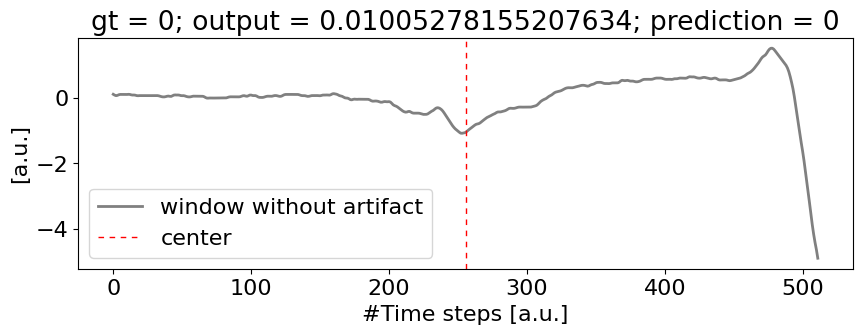

In [17]:
index = original_negmin
plt.figure(figsize=(10, 3))
example_data = test[index]["data"]
artifact_data = test[index]["data"] + test[index]["artifact"]
plt.plot(example_data, label="window without artifact", linewidth=2, color='grey')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="center", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

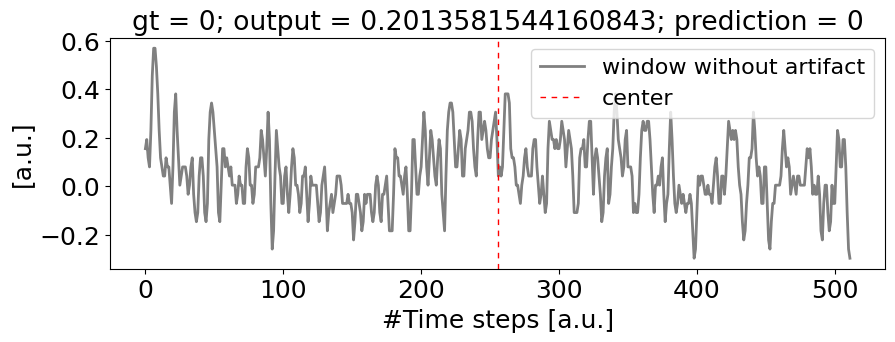

In [21]:
index = original_negmax
example_data = test[index]["data"]
artifact_data = test[index]["data"] + test[index]["artifact"]
plt.figure(figsize=(10, 3))
plt.plot(example_data, label="window without artifact", linewidth=2, color='grey')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="center", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

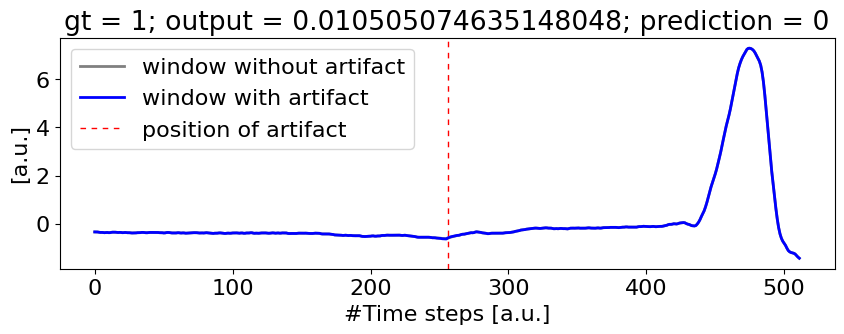

In [22]:
index = original_posmin
example_data = test[index]["data"]
artifact_data = test[index]["data"] + test[index]["artifact"]
plt.figure(figsize=(10, 3))
plt.plot(example_data, label="window without artifact", linewidth=2, color='grey')
plt.plot(artifact_data, label="window with artifact", linewidth=2, color='blue')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="position of artifact", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

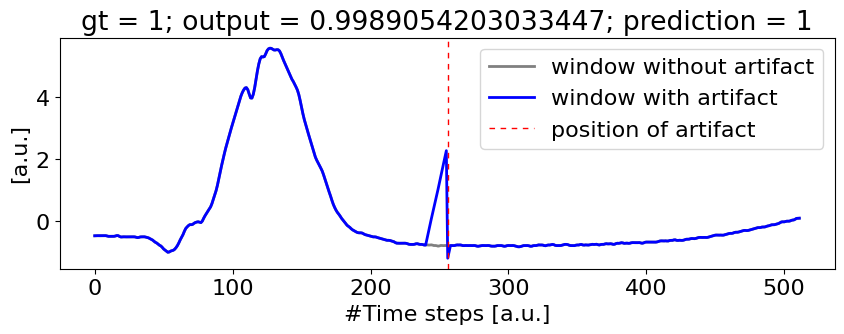

In [23]:
index = original_posmax
example_data = test[index]["data"]
artifact_data = test[index]["data"] + test[index]["artifact"]
plt.figure(figsize=(10, 3))
plt.plot(example_data, label="window without artifact", linewidth=2, color='grey')
plt.plot(artifact_data, label="window with artifact", linewidth=2, color='blue')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="position of artifact", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

## Sliding Window on Industry Data

In [50]:
import pandas as pd

test_width = 512
real_data_francois = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/francois_normalized_dataset.pickle') 

In [51]:
real_data_df = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/normalized_deviation_updated_TEST.pickle') 
ground_truth = pd.read_csv('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/gt_changes_only_relabeled_200K.csv')

In [52]:
ground_truth.drop(columns=["Unnamed: 0"], inplace=True)

In [65]:
def baseline_detector(input: torch.Tensor) -> int:   
    input.squeeze(0)
    prediction = 0

    center = int(input.shape[1]/2)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[0][1:] - input[0][:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)

    if increments[center-1] > (mean_increment + 1*std_increment):
        prediction = 1
    
    return prediction

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

all_predictions_real = pd.DataFrame(columns=['Detector_id', 'predictions'])
dist = test_width // 2

index = 1
gt = list()
preds_baseline = list()

for index, row in ground_truth[:400].iterrows():
    example_data = torch.tensor(real_data_df[0][int(row["position"]-dist) : int(row["position"]+dist)])
    
    prediction_baseline = baseline_detector(example_data.unsqueeze(0))
    preds_baseline = preds_baseline + [prediction_baseline]

    gt = gt + [row["gt"]]

all_predictions_real = pd.concat([
    all_predictions_real,
    pd.DataFrame([{
        'Detector_id': index,
        'predictions': preds_baseline
    }])
    ], ignore_index=True)

index = 2

for detector in SW_detectors:

    preds = list()

    for index, row in ground_truth[:400].iterrows():
        example_data = torch.tensor(real_data_df[0][int(row["position"]-dist) : int(row["position"]+dist)])
        # make prediction and insert into prediction
        prediction = detector(example_data.unsqueeze(0))

        # update count
        preds = preds + [prediction.numpy()] 

    new_row = pd.DataFrame([{
        'Detector_id': index ,
        'predictions': preds
    }])

    all_predictions_real = pd.concat([all_predictions_real,new_row], ignore_index=True)
    index = index +1
    print(len(all_predictions_real))


all_predictions_real = pd.concat([
    all_predictions_real,
    pd.DataFrame([{
        'Detector_id': 0,
        'predictions': gt
    }])
    ], ignore_index=True)

2
3
4
5
6
7
8
9


In [67]:
all_predictions_real.drop(all_predictions_real.tail(1).index,inplace=True)

In [107]:
all_predictions_real

,Detector_id,predictions
0,399,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,399,"[0.83090883, 0.83090883, 0.83090883, 0.8309088..."
2,399,"[0.99998415, 0.99998283, 0.99998283, 0.9999828..."
3,399,"[0.25512597, 0.08578167, 0.11797137, 0.1323422..."
4,399,"[0.2793215, 0.558609, 0.30761445, 0.29685488, ..."
5,399,"[0.84814894, 0.5491489, 0.37798136, 0.5703829,..."
6,399,"[0.9928924, 0.9297568, 0.9512292, 0.9690521, 0..."
7,399,"[0.0940011, 0.20374922, 0.15312523, 0.17135988..."
8,399,"[0.29026586, 0.45724502, 0.20606177, 0.1667097..."


In [108]:
from sklearn.metrics import fbeta_score

best_threshold_fbeta = 0.5

gt_real = ground_truth[:400]["gt"]
metrics_real = pd.DataFrame()

for index, row in all_predictions_real.iterrows():

    predictions = np.where(np.array(row['predictions']) > thresholds[index], 1, 0)
    indices_tp = [i for i, val in enumerate(predictions[gt_real==1] == 1) if val]
    indices_fn = [i for i, val in enumerate(predictions[gt_real==1] == 0) if val]

    tn, fp, fn, tp = confusion_matrix(gt_real, predictions, labels=[0, 1]).ravel()

    metric = pd.DataFrame([{
        'index': index,
        'detector': f"Detector{row['Detector_id']}",
        'threshold': thresholds[index],
        'fbeta_score': fbeta_score(gt_real, predictions, beta=0.5),
        'accuracy': accuracy_score(gt_real, predictions),
        'precision': precision_score(gt_real, predictions),
        'recall': recall_score(gt_real, predictions),
        'mse': mean_squared_error(gt_real, predictions), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp, 
        'indices_tp': indices_tp, 
        'indices_fn': indices_fn
    }])

    metrics_real = pd.concat([metrics_real, metric])


In [109]:
metrics_real

,index,detector,threshold,fbeta_score,accuracy,precision,recall,mse,tn,fp,fn,tp,indices_tp,indices_fn
0,0,Detector399,0.000,0.068807,0.5525,0.272727,0.017241,0.4475,218,8,171,3,"[3, 9, 81]","[0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 1..."
0,1,Detector399,0.525,0.645025,0.6975,0.604743,0.879310,0.3025,126,100,21,153,"[0, 1, 2, 3, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[4, 5, 6, 81, 82, 83, 84, 104, 120, 121, 154, ..."
0,2,Detector399,0.515,0.631868,0.6825,0.585455,0.925287,0.3175,112,114,13,161,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[81, 82, 83, 84, 104, 154, 155, 163, 164, 168,..."
0,3,Detector399,0.333,0.572687,0.6500,0.742857,0.298851,0.3500,208,18,122,52,"[3, 5, 9, 12, 15, 16, 19, 21, 24, 28, 30, 32, ...","[0, 1, 2, 4, 6, 7, 8, 10, 11, 13, 14, 17, 18, ..."
0,4,Detector399,0.505,0.484190,0.6025,0.590361,0.281609,0.3975,192,34,125,49,"[3, 8, 12, 15, 17, 19, 24, 27, 30, 32, 34, 36,...","[0, 1, 2, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 1..."
0,5,Detector399,0.343,0.798005,0.8125,0.815287,0.735632,0.1875,197,29,46,128,"[0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 1...","[2, 5, 13, 14, 18, 27, 31, 39, 40, 45, 49, 51,..."
0,6,Detector399,0.373,0.764818,0.8200,0.733945,0.919540,0.1800,168,58,14,160,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[81, 82, 83, 84, 122, 153, 154, 155, 164, 165,..."
0,7,Detector399,0.252,0.475460,0.6250,0.815789,0.178161,0.3750,219,7,143,31,"[5, 15, 19, 21, 35, 42, 46, 52, 54, 58, 63, 69...","[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
0,8,Detector399,0.343,0.657439,0.6925,0.752475,0.436782,0.3075,201,25,98,76,"[2, 3, 6, 8, 9, 10, 12, 15, 16, 19, 20, 21, 22...","[0, 1, 4, 5, 7, 11, 13, 14, 17, 18, 25, 26, 27..."


In [110]:
preds_FCNTrans = np.stack(all_predictions_real["predictions"][7])
gt = np.array(gt_real)

In [111]:
neg_mask = (gt == 0)
pos_mask = (gt == 1)

negative_gt_preds = preds_FCNTrans[neg_mask]
positive_gt_preds = preds_FCNTrans[pos_mask]

negmin_index = np.argmin(negative_gt_preds)
negmax_index = np.argmax(negative_gt_preds)
posmin_index = np.argmin(positive_gt_preds)
posmax_index = np.argmax(positive_gt_preds)

original_negmin = np.where(neg_mask)[0][negmin_index]
original_negmax = np.where(neg_mask)[0][negmax_index]
original_posmin = np.where(pos_mask)[0][posmin_index]
original_posmax = np.where(pos_mask)[0][posmax_index]

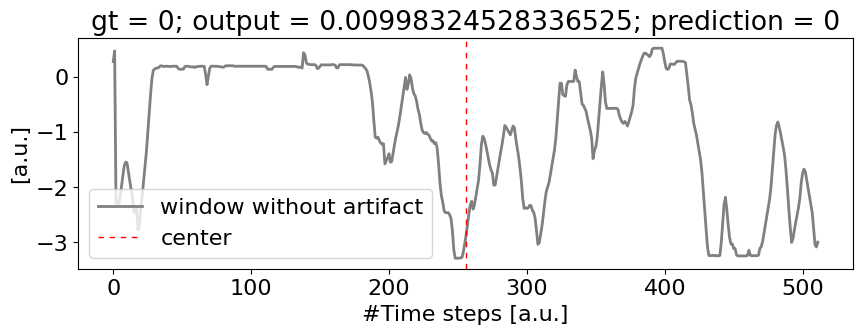

In [112]:
index = original_negmin

plt.figure(figsize=(10, 3))
example_data = torch.tensor(real_data_df[0][int(ground_truth["position"][index]-dist) : int(ground_truth["position"][index]+dist)])
plt.plot(example_data, label="window without artifact", linewidth=2, color='grey')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="center", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

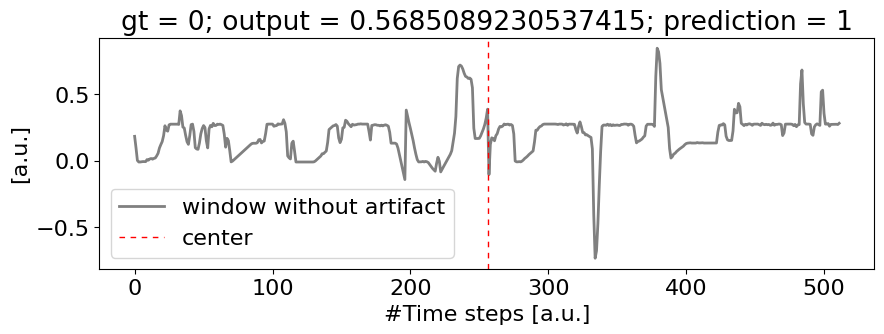

In [113]:
index = original_negmax

plt.figure(figsize=(10, 3))
example_data = torch.tensor(real_data_df[0][int(ground_truth["position"][index]-dist) : int(ground_truth["position"][index]+dist)])
plt.plot(example_data, label="window without artifact", linewidth=2, color='grey')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="center", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

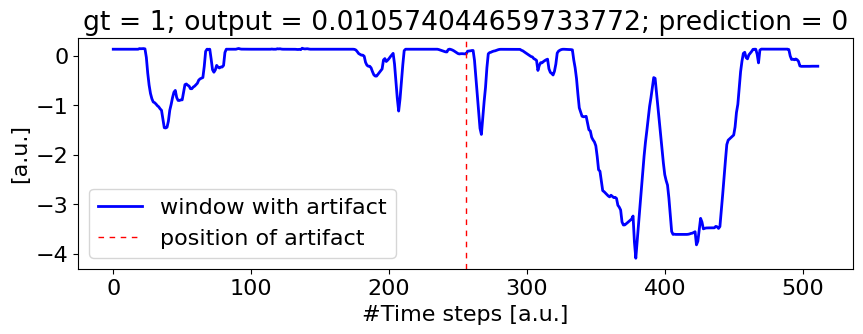

In [114]:
index = original_posmin

plt.figure(figsize=(10, 3))
example_data = torch.tensor(real_data_df[0][int(ground_truth["position"][index]-dist) : int(ground_truth["position"][index]+dist)])
plt.plot(example_data, label="window with artifact", linewidth=2, color='blue')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="position of artifact", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {gt[index]}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

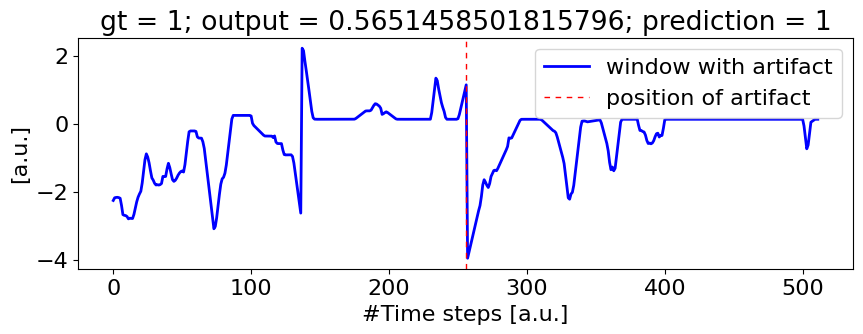

In [115]:
index = original_posmax

plt.figure(figsize=(10, 3))
example_data = torch.tensor(real_data_df[0][int(ground_truth["position"][index]-dist) : int(ground_truth["position"][index]+dist)])
plt.plot(example_data, label="window with artifact", linewidth=2, color='blue')
plt.axvline(x=256, c="red", linestyle='--', dashes=(4,4), label="position of artifact", linewidth = 1)
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"gt = {int(gt[index])}; output = {preds_FCNTrans[index]}; prediction = {int(preds_FCNTrans[index] > 0.252)}")
plt.legend()
plt.show()

## Mask Approach

In [71]:
test_width = 512
val_width = 512

test_path = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/test_mask_CiECGT512.pkl")
test = CachedArtifactDataset(file=test_path)

val_path = Path("/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/val_mask_noCiECGT512.pkl")
val = CachedArtifactDataset(file=val_path)

In [72]:
paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_FCN.ckpt" # SW FCN
mask_FCN_detector = ConvolutionDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_adaFCN.ckpt" # SW adapted FCN
mask_adaFCN_detector = ConvolutionDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_TransOnly_Lin.ckpt" # SW Transformer only GAP Lin
mask_TransOnly_Lin_detector = WindowTransformerDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_TransOnly_GAP.ckpt" # SW Transformer only totalGAP
mask_TransOnly_GAP_detector = WindowTransformerDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_CNN_Dense.ckpt" # SW 1d CNN Dense
mask_CNNDense_detector = WindowLinearDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_adaFCN_Dense.ckpt" # SW ada 1d CNN Dense
mask_adaCNNDense_detector = WindowLinearDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_CNN_Trans.ckpt" # SW 1d CNN Transformer
mask_CNNTrans_detector = WindowTransformerDetector.load_from_checkpoint(paths_mask).cpu()

paths_mask = "/workspaces/AICoE_Ramping_Artefacts/artifactory-master/models/final/Mask_adaFCN_Trans.ckpt" # SW ada 1d CNN Transformer
mask_adaCNNTrans_detector = WindowTransformerDetector.load_from_checkpoint(paths_mask).cpu()

mask_detectors = [mask_FCN_detector.eval(),
                 mask_adaFCN_detector.eval(), mask_TransOnly_Lin_detector.eval(), mask_TransOnly_GAP_detector.eval(), mask_CNNDense_detector.eval(), mask_adaCNNDense_detector.eval(), mask_CNNTrans_detector.eval(), mask_adaCNNTrans_detector.eval()
                  ]

In [74]:
def baseline_detector(input: torch.Tensor) -> torch.Tensor:
    input.squeeze(0)

    prediction = torch.zeros(input.shape)
    # flag points with very high increment as artifact
    # Calculate increments by subtracting the tensor shifted by one from the original tensor
    increments = (input[1:] - input[:-1]).abs()
    mean_increment = torch.mean(increments)
    std_increment = torch.std(increments)
    mask = increments > mean_increment + 3*std_increment
    shaped_mask = torch.cat((mask, torch.Tensor([False]))).type(torch.bool)
    prediction[shaped_mask] = 1


    return prediction

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd


all_detectors = pd.DataFrame(columns=['Detector_id', 'predictions'])

preds_base = list()
preds_fcn = list()
preds_adaFcn = list()
preds_TO_GAP = list()
preds_TO_Lin = list()
preds_fcnDense = list()
preds_adaFcnDense = list()
preds_fcnTrans = list()
preds_adaFcnTrans = list()
index = 1
gt = list()

for sample in val:

    example = sample["data"]
    stride  = 64
    window  = mask_FCN_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    # store prediction for each window
    predictions_base = torch.zeros(((length - window) // stride + 1, length))
    predictions_fcn = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaFcn = torch.zeros(((length - window) // stride + 1, length))
    predictions_TO_GAP = torch.zeros(((length - window) // stride + 1, length))
    predictions_TO_Lin = torch.zeros(((length - window) // stride + 1, length))
    predictions_fcnDense = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaFcnDense = torch.zeros(((length - window) // stride + 1, length))
    predictions_fcnTrans = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaFcnTrans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
 
        # make prediction and insert into prediction
        predictions_base[i, j : j + window] = baseline_detector(s)
        predictions_fcn[i, j : j + window] = mask_FCN_detector(s.unsqueeze(0))
        predictions_adaFcn[i, j : j + window] = mask_adaFCN_detector(s.unsqueeze(0))
        predictions_TO_GAP[i, j : j + window] = mask_TransOnly_GAP_detector(s.unsqueeze(0))
        predictions_TO_Lin[i, j : j + window] = mask_TransOnly_Lin_detector(s.unsqueeze(0))
        predictions_fcnDense[i, j : j + window] = mask_CNNDense_detector(s.unsqueeze(0))
        predictions_adaFcnDense[i, j : j + window] = mask_adaCNNDense_detector(s.unsqueeze(0))
        predictions_fcnTrans[i, j : j + window] = mask_CNNTrans_detector(s.unsqueeze(0))
        predictions_adaFcnTrans[i, j : j + window] = mask_adaCNNTrans_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    preds_base = preds_base + (predictions_base.sum(axis=0) / masks).tolist()
    preds_fcn = preds_fcn + (predictions_fcn.sum(axis=0) / masks).tolist()
    preds_adaFcn = preds_adaFcn + (predictions_adaFcn.sum(axis=0) / masks).tolist()
    preds_TO_GAP = preds_TO_GAP + (predictions_TO_GAP.sum(axis=0) / masks).tolist()
    preds_TO_Lin = preds_TO_Lin + (predictions_TO_Lin.sum(axis=0) / masks).tolist()
    preds_fcnDense = preds_fcnDense + (predictions_fcnDense.sum(axis=0) / masks).tolist()
    preds_adaFcnDense = preds_adaFcnDense + (predictions_adaFcnDense.sum(axis=0) / masks).tolist()
    preds_fcnTrans = preds_fcnTrans + (predictions_fcnTrans.sum(axis=0) / masks).tolist()
    preds_adaFcnTrans = preds_adaFcnTrans + (predictions_adaFcnTrans.sum(axis=0) / masks).tolist()
    gt = gt + list(sample["mask"])

In [15]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix

max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_base > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_base = threshold

max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_fcn > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_fcn = threshold

max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_adaFcn > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_adaFcn = threshold
        

max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_TO_GAP > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_TO_GAP = threshold


max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_TO_Lin > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_TO_Lin = threshold
        
        
max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_fcnDense > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_fcnDense = threshold
        
        
max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_adaFcnDense > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_adaFcnDense = threshold
        
        
max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_fcnTrans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_fcnTrans = threshold


max_fbeta = 0
for threshold in np.linspace(0,  1,  100):
    predictions = np.where(preds_adaFcnTrans > threshold, 1, 0)

    fbeta = fbeta_score(gt, predictions, average='macro', beta=0.5)

    if (fbeta > max_fbeta):
        max_fbeta = fbeta
        best_threshold_fbeta_adaFcnTrans = threshold

KeyboardInterrupt: 

In [76]:
best_threshold_fbeta_base = 0.5
best_threshold_fbeta_fcn = 0.505
best_threshold_fbeta_adaFcn = 0.515
best_threshold_fbeta_TO_GAP = 0.596
best_threshold_fbeta_TO_Lin = 0.758
best_threshold_fbeta_fcnDense = 0.636
best_threshold_fbeta_adaFcnDense = 0.626
best_threshold_fbeta_fcnTrans= 0.687
best_threshold_fbeta_adaFcnTrans = 0.545

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix, fbeta_score
import pandas as pd

metrics = pd.DataFrame()
index = 0

gt = list()

for sample in test:
    example = sample["data"]
    stride  = 64
    window  = mask_FCN_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example + sample["artifact"])

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_fcn = torch.zeros(((length - window) // stride + 1, length))
    predictions_adafcn = torch.zeros(((length - window) // stride + 1, length))
    predictions_transOnly_GAP = torch.zeros(((length - window) // stride + 1, length))
    predictions_transOnly_Lin = torch.zeros(((length - window) // stride + 1, length))
    predictions_CNNDense = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaCNNDense = torch.zeros(((length - window) // stride + 1, length))
    predictions_FCNTrans = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaFCNTrans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction

        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_fcn[i, j : j + window] = mask_FCN_detector(s.unsqueeze(0))
        predictions_adafcn[i, j : j + window] = mask_adaFCN_detector(s.unsqueeze(0))
        predictions_transOnly_GAP[i, j : j + window] = mask_TransOnly_GAP_detector(s.unsqueeze(0))
        predictions_transOnly_Lin[i, j : j + window] = mask_TransOnly_Lin_detector(s.unsqueeze(0))
        predictions_CNNDense[i, j : j + window] = mask_CNNDense_detector(s.unsqueeze(0))
        predictions_adaCNNDense[i, j : j + window] = mask_adaCNNDense_detector(s.unsqueeze(0))
        predictions_FCNTrans[i, j : j + window] = mask_CNNTrans_detector(s.unsqueeze(0))
        predictions_adaFCNTrans[i, j : j + window] = mask_adaCNNTrans_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    gt = gt + sample["mask"].tolist()

    preds_baseline = predictions_baseline.sum(axis=0) / masks
    predictions_baseline = np.where(preds_baseline.numpy() > best_threshold_fbeta_base, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_baseline, labels=[0, 1]).ravel()
    new_row_baseline = pd.DataFrame([{
        'index': index,
        'detector': 'Stoch. Baseline',
        'threshold': best_threshold_fbeta_base,
        'fbeta_score': fbeta_score(sample["mask"], predictions_baseline, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_baseline),
        'precision': precision_score(sample["mask"], predictions_baseline),
        'recall': recall_score(sample["mask"], predictions_baseline),
        'mse': mean_squared_error(sample["mask"], predictions_baseline), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_baseline
    }])

    preds_fcn = predictions_fcn.sum(axis=0) / masks
    predictions_fcn = np.where(preds_fcn.numpy() > best_threshold_fbeta_fcn, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_fcn, labels=[0, 1]).ravel()
    new_row_fcn = pd.DataFrame([{
        'index': index,
        'detector': 'FCN',
        'threshold': best_threshold_fbeta_fcn,
        'fbeta_score': fbeta_score(sample["mask"], predictions_fcn, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_fcn),
        'precision': precision_score(sample["mask"], predictions_fcn),
        'recall': recall_score(sample["mask"], predictions_fcn),
        'mse': mean_squared_error(sample["mask"], predictions_fcn), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_fcn
    }])

    preds_adafcn = predictions_adafcn.sum(axis=0) / masks
    predictions_adafcn = np.where(preds_adafcn.numpy() > best_threshold_fbeta_adaFcn, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_adafcn, labels=[0, 1]).ravel()
    new_row_adafcn = pd.DataFrame([{
        'index': index,
        'detector': 'adapted FCN',
        'threshold': best_threshold_fbeta_adaFcn,
        'fbeta_score': fbeta_score(sample["mask"], predictions_adafcn, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_adafcn),
        'precision': precision_score(sample["mask"], predictions_adafcn),
        'recall': recall_score(sample["mask"], predictions_adafcn),
        'mse': mean_squared_error(sample["mask"], predictions_adafcn), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_adafcn
    }])

    preds_transOnly_GAP = predictions_transOnly_GAP.sum(axis=0) / masks
    predictions_transOnly_GAP = np.where(preds_transOnly_GAP.numpy() > best_threshold_fbeta_TO_GAP, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_transOnly_GAP, labels=[0, 1]).ravel()
    new_row_TO_GAP = pd.DataFrame([{
        'index': index,
        'detector': 'Trans Only GAP',
        'threshold': best_threshold_fbeta_TO_GAP,
        'fbeta_score': fbeta_score(sample["mask"], predictions_transOnly_GAP, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_transOnly_GAP),
        'precision': precision_score(sample["mask"], predictions_transOnly_GAP),
        'recall': recall_score(sample["mask"], predictions_transOnly_GAP),
        'mse': mean_squared_error(sample["mask"], predictions_transOnly_GAP),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction':preds_transOnly_GAP
    }])

    preds_transOnly_Lin = predictions_transOnly_Lin.sum(axis=0) / masks
    predictions_transOnly_Lin = np.where(preds_transOnly_Lin.numpy() > best_threshold_fbeta_TO_Lin, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_transOnly_Lin, labels=[0, 1]).ravel()
    new_row_TO_Lin = pd.DataFrame([{
        'index': index,
        'detector': 'Trans Only Lin',
        'threshold': best_threshold_fbeta_TO_Lin,
        'fbeta_score': fbeta_score(sample["mask"], predictions_transOnly_Lin, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_transOnly_Lin),
        'precision': precision_score(sample["mask"], predictions_transOnly_Lin),
        'recall': recall_score(sample["mask"], predictions_transOnly_Lin),
        'mse': mean_squared_error(sample["mask"], predictions_transOnly_Lin),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction':preds_transOnly_Lin
    }])

    preds_CNNDense = predictions_CNNDense.sum(axis=0) / masks
    predictions_CNNDense = np.where(preds_CNNDense.numpy() > best_threshold_fbeta_fcnDense, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_CNNDense, labels=[0, 1]).ravel()
    new_row_FCNDense = pd.DataFrame([{
        'index': index,
        'detector': 'FCN dense',
        'threshold': best_threshold_fbeta_fcnDense,
        'fbeta_score': fbeta_score(sample["mask"], predictions_CNNDense, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_CNNDense),
        'precision': precision_score(sample["mask"], predictions_CNNDense),
        'recall': recall_score(sample["mask"], predictions_CNNDense),
        'mse': mean_squared_error(sample["mask"], predictions_CNNDense),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction':preds_CNNDense
    }])

    preds_adaCNNDense = predictions_adaCNNDense.sum(axis=0) / masks
    predictions_adaCNNDense = np.where(preds_adaCNNDense.numpy() > best_threshold_fbeta_adaFcnDense, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_adaCNNDense, labels=[0, 1]).ravel()
    new_row_adaFCN_Dense = pd.DataFrame([{
        'index': index,
        'detector': 'adaFCN Dense',
        'threshold': best_threshold_fbeta_adaFcnDense,
        'fbeta_score': fbeta_score(sample["mask"], predictions_adaCNNDense, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_adaCNNDense),
        'precision': precision_score(sample["mask"], predictions_adaCNNDense),
        'recall': recall_score(sample["mask"], predictions_adaCNNDense),
        'mse': mean_squared_error(sample["mask"], predictions_adaCNNDense),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_adaCNNDense
    }])

    preds_FCNTrans = predictions_FCNTrans.sum(axis=0) / masks
    predictions_FCNTrans = np.where(preds_FCNTrans.numpy() > best_threshold_fbeta_fcnTrans, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_FCNTrans, labels=[0, 1]).ravel()
    new_row_FCNTrans = pd.DataFrame([{
        'index': index,
        'detector': 'FCN Trans.',
        'threshold': best_threshold_fbeta_fcnTrans,
        'fbeta_score': fbeta_score(sample["mask"], predictions_FCNTrans, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_FCNTrans),
        'precision': precision_score(sample["mask"], predictions_FCNTrans),
        'recall': recall_score(sample["mask"], predictions_FCNTrans),
        'mse': mean_squared_error(sample["mask"], predictions_FCNTrans),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_FCNTrans
    }])

    preds_adaFCNTrans = predictions_adaFCNTrans.sum(axis=0) / masks
    predictions_adaFCNTrans = np.where(preds_adaFCNTrans.numpy() > best_threshold_fbeta_adaFcnTrans, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_adaFCNTrans, labels=[0, 1]).ravel()
    new_row_adaFCN_Trans = pd.DataFrame([{
        'index': index,
        'detector': 'adaFCN Trans.',
        'threshold': best_threshold_fbeta_adaFcnTrans,
        'fbeta_score': fbeta_score(sample["mask"], predictions_adaFCNTrans, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_adaFCNTrans),
        'precision': precision_score(sample["mask"], predictions_adaFCNTrans),
        'recall': recall_score(sample["mask"], predictions_adaFCNTrans),
        'mse': mean_squared_error(sample["mask"], predictions_adaFCNTrans),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_adaFCNTrans
    }])

    metrics = pd.concat([metrics, new_row_baseline, new_row_fcn, new_row_adafcn, new_row_TO_GAP, new_row_TO_Lin, new_row_FCNDense, new_row_adaFCN_Dense, new_row_FCNTrans, new_row_adaFCN_Trans], ignore_index=True)
    index = index+1


/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precis

In [79]:
metrics

,index,detector,threshold,fbeta_score,accuracy,precision,recall,mse,tn,fp,fn,tp,prediction
0,0,Stoch. Baseline,0.500,0.000000,0.984375,0.000,0.000000,0.015625,504,6,2,0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,0,FCN,0.505,0.000000,0.996094,0.000,0.000000,0.003906,510,0,2,0,"[tensor(0.), tensor(0.), tensor(0.0052), tenso..."
2,0,adapted FCN,0.515,0.000000,0.996094,0.000,0.000000,0.003906,510,0,2,0,"[tensor(0.0359), tensor(0.0249), tensor(0.0142..."
3,0,Trans Only GAP,0.596,0.000000,0.953125,0.000,0.000000,0.046875,488,22,2,0,"[tensor(-0.2971), tensor(-0.3050), tensor(-0.3..."
4,0,Trans Only Lin,0.758,0.000000,0.996094,0.000,0.000000,0.003906,510,0,2,0,"[tensor(-0.0046), tensor(-0.0050), tensor(-0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18427,2047,Trans Only Lin,0.758,0.979899,0.992188,1.000,0.906977,0.007812,469,0,4,39,"[tensor(-0.0063), tensor(-0.0063), tensor(-0.0..."
18428,2047,FCN dense,0.636,0.162602,0.892578,0.200,0.093023,0.107422,453,16,39,4,"[tensor(0.5528), tensor(0.6615), tensor(0.6204..."
18429,2047,adaFCN Dense,0.626,0.093458,0.892578,0.125,0.046512,0.107422,455,14,41,2,"[tensor(0.3067), tensor(0.3856), tensor(0.4330..."
18430,2047,FCN Trans.,0.687,0.798319,0.953125,1.000,0.441860,0.046875,469,0,24,19,"[tensor(0.0056), tensor(0.0056), tensor(0.0056..."


In [80]:
conf_mat_values = metrics.groupby('index')[['tn', 'fp', 'fn', 'tp']].sum()

In [81]:
fp_sorted = conf_mat_values.sort_values(by="fp")

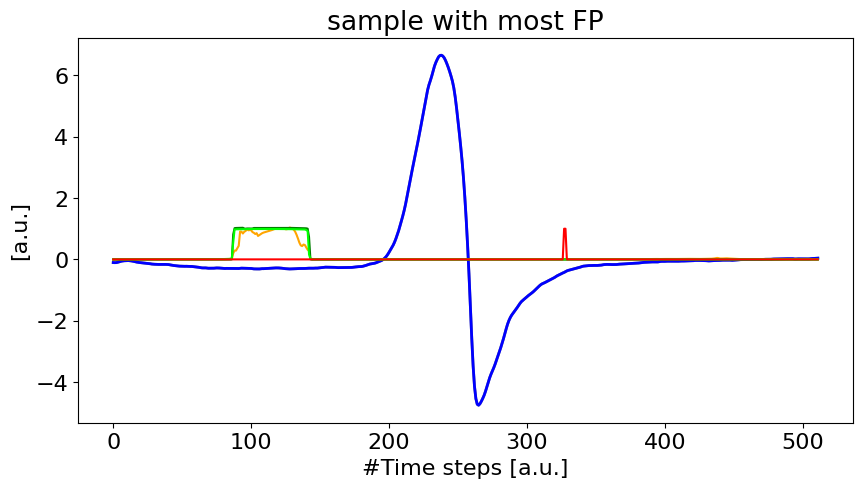

In [84]:
index = -1

sample = test[fp_sorted.iloc[index].name]
predictions_trans = metrics.loc[(metrics['index'] == fp_sorted.iloc[0].name) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == fp_sorted.iloc[0].name) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == fp_sorted.iloc[0].name) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='grey')
plt.plot((sample["data"] + sample["artifact"]), label="window with artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with most FP")
# plt.legend()
plt.show()

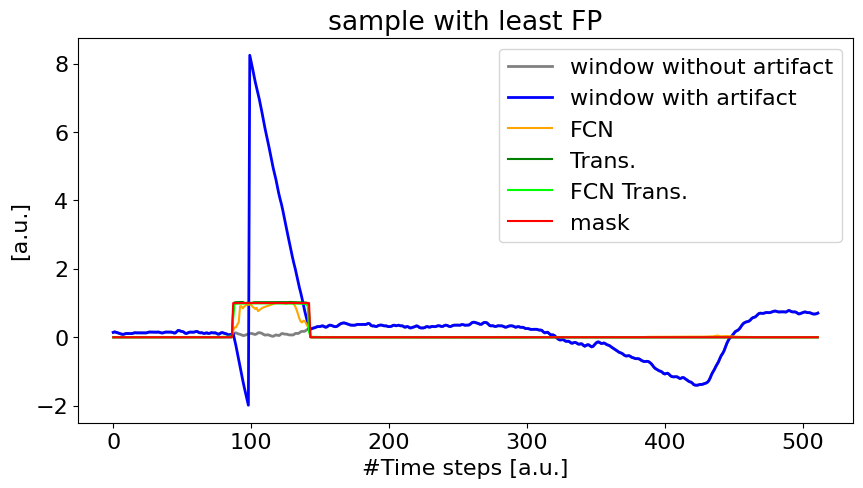

In [85]:
index = 0

sample = test[fp_sorted.iloc[index].name]
predictions_trans = metrics.loc[(metrics['index'] == fp_sorted.iloc[0].name) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == fp_sorted.iloc[0].name) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == fp_sorted.iloc[0].name) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='grey')
plt.plot((sample["data"] + sample["artifact"]), label="window with artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with least FP")
plt.legend()
plt.show()

In [86]:
fn_sorted = conf_mat_values.sort_values(by="fn")

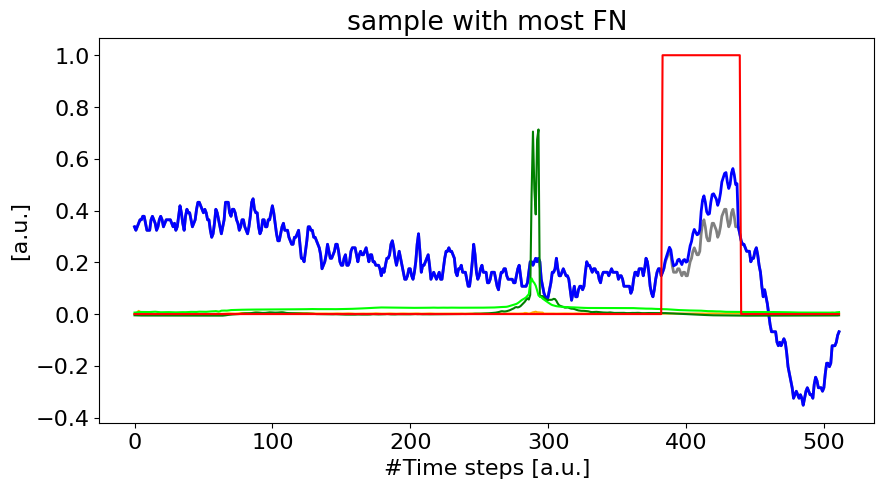

In [87]:
index = -1

sample = test[fn_sorted.iloc[index].name]
predictions_trans = metrics.loc[(metrics['index'] == fn_sorted.iloc[0].name) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == fn_sorted.iloc[0].name) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == fn_sorted.iloc[0].name) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='grey')
plt.plot((sample["data"] + sample["artifact"]), label="window with artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with most FN")
# plt.legend(loc=2)
plt.show()

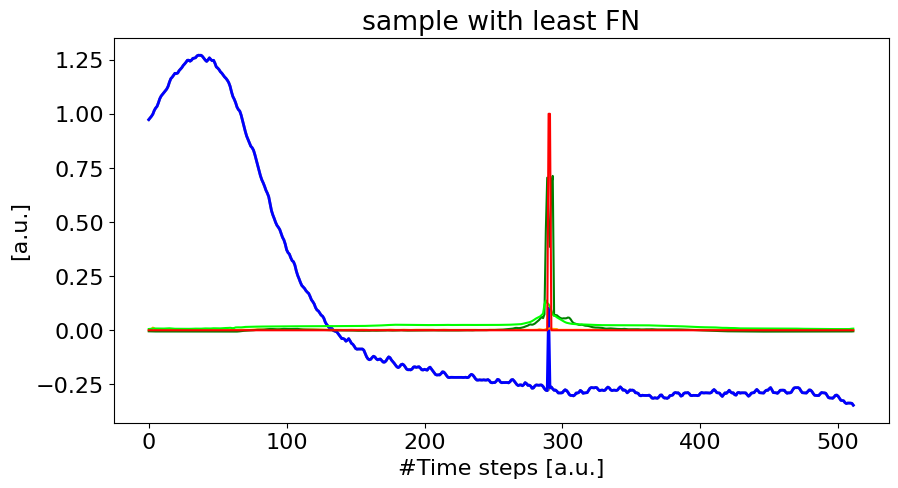

In [88]:
index = 0

sample = test[fn_sorted.iloc[index].name]
predictions_trans = metrics.loc[(metrics['index'] == fn_sorted.iloc[0].name) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == fn_sorted.iloc[0].name) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == fn_sorted.iloc[0].name) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='grey')
plt.plot((sample["data"] + sample["artifact"]), label="window with artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with least FN")
#plt.legend()
plt.show()

In [89]:
metrics_total = metrics.groupby('detector')[['fbeta_score','accuracy', 'precision', 'recall', 'mse']].mean()
conf_mat_values = metrics.groupby('detector')[['tn', 'fp', 'fn', 'tp']].sum()

In [90]:
metrics_total.round(3)

,fbeta_score,accuracy,precision,recall,mse
detector,,,,,
FCN,0.499,0.941,0.535,0.561,0.059
FCN Trans.,0.750,0.985,0.780,0.724,0.015
FCN dense,0.053,0.906,0.063,0.041,0.094
Stoch. Baseline,0.162,0.938,0.734,0.078,0.062
Trans Only GAP,0.534,0.943,0.576,0.555,0.057
Trans Only Lin,0.745,0.985,0.769,0.718,0.015
adaFCN Dense,0.059,0.914,0.074,0.039,0.086
adaFCN Trans.,0.575,0.962,0.599,0.551,0.038
adapted FCN,0.577,0.967,0.578,0.630,0.033


In [91]:
df = ((conf_mat_values/(conf_mat_values.iloc[0].sum()))*100).round(1)
df[["tp", "fp", "fn", "tn"]]

,tp,fp,fn,tn
detector,,,,
FCN,3.8,3.7,2.2,90.3
FCN Trans.,4.7,0.2,1.3,93.8
FCN dense,0.2,3.7,5.7,90.4
Stoch. Baseline,0.2,0.5,5.7,93.6
Trans Only GAP,3.5,3.3,2.4,90.8
Trans Only Lin,4.8,0.3,1.2,93.8
adaFCN Dense,0.2,2.9,5.7,91.1
adaFCN Trans.,3.7,1.6,2.3,92.5
adapted FCN,4.4,1.8,1.6,92.3


In [92]:
conf_mat_values

,tn,fp,fn,tp
detector,,,,
FCN,946923,39183,22699,39771
FCN Trans.,983729,2377,13315,49155
FCN dense,947712,38394,59904,2566
Stoch. Baseline,981308,4798,60125,2345
Trans Only GAP,951993,34113,25429,37041
Trans Only Lin,983043,3063,12510,49960
adaFCN Dense,955775,30331,60033,2437
adaFCN Trans.,969512,16594,23640,38830
adapted FCN,967744,18362,16726,45744


In [93]:
metrics_total

,fbeta_score,accuracy,precision,recall,mse
detector,,,,,
FCN,0.499440,0.940985,0.535479,0.560625,0.059015
FCN Trans.,0.749753,0.985035,0.779771,0.724383,0.014965
FCN dense,0.053122,0.906256,0.062646,0.041050,0.093744
Stoch. Baseline,0.161936,0.938085,0.734420,0.077716,0.061915
Trans Only GAP,0.534305,0.943216,0.576089,0.555251,0.056784
Trans Only Lin,0.744591,0.985148,0.768772,0.718455,0.014852
adaFCN Dense,0.058593,0.913822,0.074371,0.038900,0.086178
adaFCN Trans.,0.574926,0.961630,0.599191,0.551402,0.038370
adapted FCN,0.577023,0.966537,0.577619,0.630164,0.033463


In [94]:
conf_mat_values

,tn,fp,fn,tp
detector,,,,
FCN,946923,39183,22699,39771
FCN Trans.,983729,2377,13315,49155
FCN dense,947712,38394,59904,2566
Stoch. Baseline,981308,4798,60125,2345
Trans Only GAP,951993,34113,25429,37041
Trans Only Lin,983043,3063,12510,49960
adaFCN Dense,955775,30331,60033,2437
adaFCN Trans.,969512,16594,23640,38830
adapted FCN,967744,18362,16726,45744


In [95]:
test_width = 512

test_file = Path(f"../data/test_real_{test_width}.pkl")
start_index = 13100
final_index = 145355 # end of last annotated artifact

n = 130 # 13100 + 130*1024 = 146220 - till there we have labels
# test_file = Path(f"../data/test_real{test_width}.pkl")
# test_dataset = ["normalized_deviation_updated"]
if not test_file.exists():
    real_data_df = pd.read_pickle('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/real/normalized_deviation_updated_TEST.pickle') 
    real_data = real_data_df[0]
    ground_truth = pd.read_csv('/workspaces/AICoE_Ramping_Artefacts/artifactory-master/data/gt_realData.csv')
    test_ds = TestArtifactDataset.generate(
        start_index=start_index,
        labels=ground_truth,
        width=test_width,
        n=n,
        data=real_data,
        to=Path(f"../data/test_real_{test_width}.pkl"),
    )
else:
    test_ds = TestArtifactDataset(file=test_file)

In [96]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, confusion_matrix
import pandas as pd

metrics = pd.DataFrame(columns=['detector', 'accuracy', 'precision', 'recall', 'mse'])
index = 0

gt = list()

for sample in test_ds:
    example = sample["data"]
    stride  = 64
    window  = mask_FCN_detector.window
    length  = len(example)

    # add artifact to data
    example_data = torch.tensor(example)

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_fcn = torch.zeros(((length - window) // stride + 1, length))
    predictions_adafcn = torch.zeros(((length - window) // stride + 1, length))
    predictions_transOnly_GAP = torch.zeros(((length - window) // stride + 1, length))
    predictions_transOnly_Lin = torch.zeros(((length - window) // stride + 1, length))
    predictions_CNNDense = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaCNNDense = torch.zeros(((length - window) // stride + 1, length))
    predictions_FCNTrans = torch.zeros(((length - window) // stride + 1, length))
    predictions_adaFCNTrans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction

        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_fcn[i, j : j + window] = mask_FCN_detector(s.unsqueeze(0))
        predictions_adafcn[i, j : j + window] = mask_adaFCN_detector(s.unsqueeze(0))
        predictions_transOnly_GAP[i, j : j + window] = mask_TransOnly_GAP_detector(s.unsqueeze(0))
        predictions_transOnly_Lin[i, j : j + window] = mask_TransOnly_Lin_detector(s.unsqueeze(0))
        predictions_CNNDense[i, j : j + window] = mask_CNNDense_detector(s.unsqueeze(0))
        predictions_adaCNNDense[i, j : j + window] = mask_adaCNNDense_detector(s.unsqueeze(0))
        predictions_FCNTrans[i, j : j + window] = mask_CNNTrans_detector(s.unsqueeze(0))
        predictions_adaFCNTrans[i, j : j + window] = mask_adaCNNTrans_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    gt = gt + sample["mask"]['0'].tolist()

    preds_base = predictions_baseline.sum(axis=0) / masks
    predictions_baseline = np.where(preds_base.numpy() > best_threshold_fbeta_base, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_baseline, labels=[0, 1]).ravel()
    new_row_baseline = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'Stoch. Baseline',
        'threshold': best_threshold_fbeta_base,
        'fbeta_score': fbeta_score(sample["mask"], predictions_baseline, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_baseline),
        'precision': precision_score(sample["mask"], predictions_baseline),
        'recall': recall_score(sample["mask"], predictions_baseline),
        'mse': mean_squared_error(sample["mask"], predictions_baseline), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_base
    }])

    preds_FCN = predictions_fcn.sum(axis=0) / masks
    predictions_fcn = np.where(preds_FCN.numpy() > best_threshold_fbeta_fcn, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_fcn, labels=[0, 1]).ravel()
    new_row_fcn = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'FCN',
        'threshold': best_threshold_fbeta_fcn,
        'fbeta_score': fbeta_score(sample["mask"], predictions_fcn, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_fcn),
        'precision': precision_score(sample["mask"], predictions_fcn),
        'recall': recall_score(sample["mask"], predictions_fcn),
        'mse': mean_squared_error(sample["mask"], predictions_fcn), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_FCN
    }])

    preds_adaFCN = predictions_adafcn.sum(axis=0) / masks
    predictions_adafcn = np.where(preds_adaFCN.numpy() > best_threshold_fbeta_adaFcn, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_adafcn, labels=[0, 1]).ravel()
    new_row_adafcn = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'adapted FCN',
        'threshold': best_threshold_fbeta_adaFcn,
        'fbeta_score': fbeta_score(sample["mask"], predictions_adafcn, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_adafcn),
        'precision': precision_score(sample["mask"], predictions_adafcn),
        'recall': recall_score(sample["mask"], predictions_adafcn),
        'mse': mean_squared_error(sample["mask"], predictions_adafcn), 
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_adaFCN
    }])

    preds_transOnlyGAP = predictions_transOnly_GAP.sum(axis=0) / masks
    predictions_transOnly_GAP = np.where(preds_transOnlyGAP.numpy() > best_threshold_fbeta_TO_GAP, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_transOnly_GAP, labels=[0, 1]).ravel()
    new_row_TO_GAP = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'Trans Only GAP',
        'threshold': best_threshold_fbeta_TO_GAP,
        'fbeta_score': fbeta_score(sample["mask"], predictions_transOnly_GAP, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_transOnly_GAP),
        'precision': precision_score(sample["mask"], predictions_transOnly_GAP),
        'recall': recall_score(sample["mask"], predictions_transOnly_GAP),
        'mse': mean_squared_error(sample["mask"], predictions_transOnly_GAP),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_transOnlyGAP
    }])

    preds_transOnlyLin = predictions_transOnly_Lin.sum(axis=0) / masks
    predictions_transOnly_Lin = np.where(preds_transOnlyLin.numpy() > best_threshold_fbeta_TO_Lin, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_transOnly_Lin, labels=[0, 1]).ravel()
    new_row_TO_Lin = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'Trans Only Lin',
        'threshold': best_threshold_fbeta_TO_Lin,
        'fbeta_score': fbeta_score(sample["mask"], predictions_transOnly_Lin, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_transOnly_Lin),
        'precision': precision_score(sample["mask"], predictions_transOnly_Lin),
        'recall': recall_score(sample["mask"], predictions_transOnly_Lin),
        'mse': mean_squared_error(sample["mask"], predictions_transOnly_Lin),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_transOnlyLin
    }])

    preds_CNNDense = predictions_CNNDense.sum(axis=0) / masks
    predictions_CNNDense = np.where(preds_CNNDense.numpy() > best_threshold_fbeta_fcnDense, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_CNNDense, labels=[0, 1]).ravel()
    new_row_FCNDense = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'FCN dense',
        'threshold': best_threshold_fbeta_fcnDense,
        'fbeta_score': fbeta_score(sample["mask"], predictions_CNNDense, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_CNNDense),
        'precision': precision_score(sample["mask"], predictions_CNNDense),
        'recall': recall_score(sample["mask"], predictions_CNNDense),
        'mse': mean_squared_error(sample["mask"], predictions_CNNDense),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_CNNDense
    }])

    preds_adaCNNDense = predictions_adaCNNDense.sum(axis=0) / masks
    predictions_adaCNNDense = np.where(preds_adaCNNDense.numpy() > best_threshold_fbeta_adaFcnDense, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_adaCNNDense, labels=[0, 1]).ravel()
    new_row_adaFCN_Dense = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'adaFCN Dense',
        'threshold': best_threshold_fbeta_adaFcnDense,
        'fbeta_score': fbeta_score(sample["mask"], predictions_adaCNNDense, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_adaCNNDense),
        'precision': precision_score(sample["mask"], predictions_adaCNNDense),
        'recall': recall_score(sample["mask"], predictions_adaCNNDense),
        'mse': mean_squared_error(sample["mask"], predictions_adaCNNDense),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_adaCNNDense
    }])

    preds_FCNTrans = predictions_FCNTrans.sum(axis=0) / masks
    predictions_FCNTrans = np.where(preds_FCNTrans.numpy() > best_threshold_fbeta_fcnTrans, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_FCNTrans, labels=[0, 1]).ravel()
    new_row_FCNTrans = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'FCN Trans.',
        'threshold': best_threshold_fbeta_fcnTrans,
        'fbeta_score': fbeta_score(sample["mask"], predictions_FCNTrans, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_FCNTrans),
        'precision': precision_score(sample["mask"], predictions_FCNTrans),
        'recall': recall_score(sample["mask"], predictions_FCNTrans),
        'mse': mean_squared_error(sample["mask"], predictions_FCNTrans),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_FCNTrans
    }])

    preds_adaFCNTrans = predictions_adaFCNTrans.sum(axis=0) / masks
    predictions_adaFCNTrans = np.where(preds_adaFCNTrans.numpy() > best_threshold_fbeta_adaFcnTrans, 1, 0)
    tn, fp, fn, tp = confusion_matrix(sample["mask"], predictions_adaFCNTrans, labels=[0, 1]).ravel()
    new_row_adaFCN_Trans = pd.DataFrame([{
        'index': index,
        'start_index': sample["start_index"],
        'detector': 'adaFCN Trans.',
        'threshold': best_threshold_fbeta_adaFcnTrans,
        'fbeta_score': fbeta_score(sample["mask"], predictions_adaFCNTrans, beta=0.5),
        'accuracy': accuracy_score(sample["mask"], predictions_adaFCNTrans),
        'precision': precision_score(sample["mask"], predictions_adaFCNTrans),
        'recall': recall_score(sample["mask"], predictions_adaFCNTrans),
        'mse': mean_squared_error(sample["mask"], predictions_adaFCNTrans),
        'tn': tn,
        'fp': fp, 
        'fn': fn, 
        'tp': tp,
        'prediction': preds_adaFCNTrans
    }])

    metrics = pd.concat([metrics, new_row_baseline, new_row_fcn, new_row_adafcn, new_row_TO_GAP, new_row_TO_Lin, new_row_FCNDense, new_row_adaFCN_Dense, new_row_FCNTrans, new_row_adaFCN_Trans], ignore_index=True)
    index = index+1


/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precis

In [97]:
metrics

,detector,accuracy,precision,recall,mse,index,start_index,threshold,fbeta_score,tn,fp,fn,tp,prediction
0,Stoch. Baseline,0.826172,0.500000,0.022472,0.173828,0.0,13100.0,0.500,0.095238,421.0,2.0,87.0,2.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
1,FCN,0.808594,0.363636,0.134831,0.191406,0.0,13100.0,0.505,0.271493,402.0,21.0,77.0,12.0,"[tensor(0.), tensor(0.), tensor(0.), tensor(0...."
2,adapted FCN,0.802734,0.403226,0.280899,0.197266,0.0,13100.0,0.515,0.370920,386.0,37.0,64.0,25.0,"[tensor(0.0100), tensor(0.0045), tensor(0.), t..."
3,Trans Only GAP,0.753906,0.000000,0.000000,0.246094,0.0,13100.0,0.596,0.000000,386.0,37.0,89.0,0.0,"[tensor(-0.3452), tensor(-0.3505), tensor(-0.3..."
4,Trans Only Lin,0.734375,0.000000,0.000000,0.265625,0.0,13100.0,0.758,0.000000,376.0,47.0,89.0,0.0,"[tensor(-0.0058), tensor(-0.0058), tensor(-0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,Trans Only Lin,1.000000,0.000000,0.000000,0.000000,129.0,79148.0,0.758,0.000000,512.0,0.0,0.0,0.0,"[tensor(-0.0060), tensor(-0.0060), tensor(-0.0..."
1166,FCN dense,0.960938,0.000000,0.000000,0.039062,129.0,79148.0,0.636,0.000000,492.0,20.0,0.0,0.0,"[tensor(0.5528), tensor(0.6615), tensor(0.6204..."
1167,adaFCN Dense,0.968750,0.000000,0.000000,0.031250,129.0,79148.0,0.626,0.000000,496.0,16.0,0.0,0.0,"[tensor(0.3067), tensor(0.3856), tensor(0.4330..."
1168,FCN Trans.,1.000000,0.000000,0.000000,0.000000,129.0,79148.0,0.687,0.000000,512.0,0.0,0.0,0.0,"[tensor(0.0052), tensor(0.0055), tensor(0.0054..."


In [98]:
conf_mat_values = metrics.groupby("index")[['tn', 'fp', 'fn', 'tp']].sum()

In [99]:
fp_sorted = metrics.sort_values(by="fp")

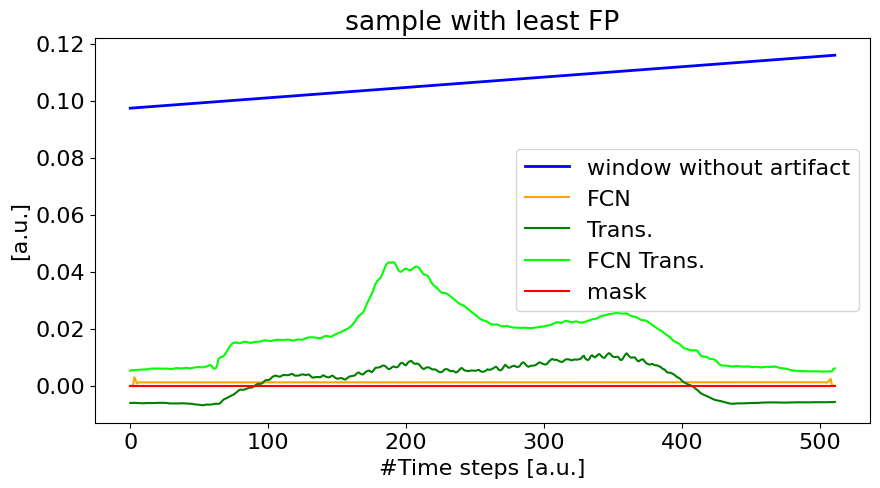

In [100]:
ind = 0

sample = test_ds[int(fp_sorted.iloc[ind]["index"])]
predictions_trans = metrics.loc[(metrics['index'] == int(fp_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == int(fp_sorted.iloc[ind]["index"])) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == int(fp_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(range(len(sample["mask"])), sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with least FP")
plt.legend()
plt.show()

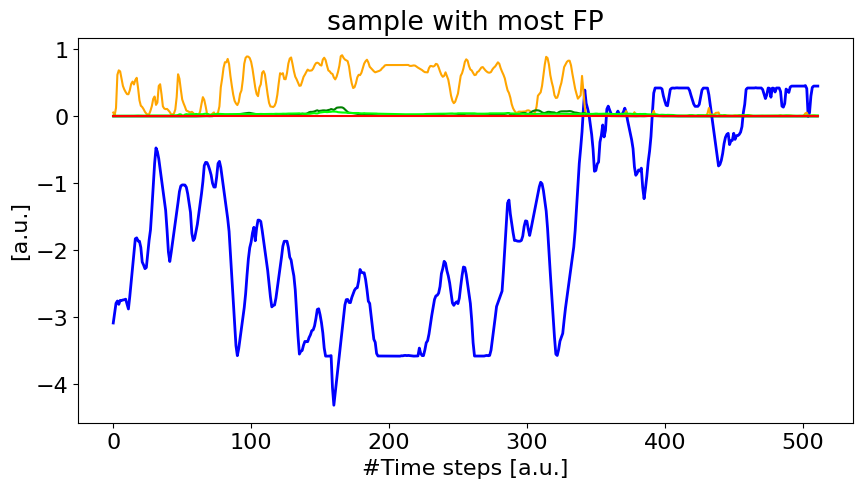

In [101]:
ind = -1

sample = test_ds[int(fp_sorted.iloc[ind]["index"])]
predictions_trans = metrics.loc[(metrics['index'] == int(fp_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == int(fp_sorted.iloc[ind]["index"])) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == int(fp_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(range(len(sample["mask"])), sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with most FP")
# plt.legend()
plt.show()

In [102]:
fn_sorted = metrics.sort_values(by="fn")

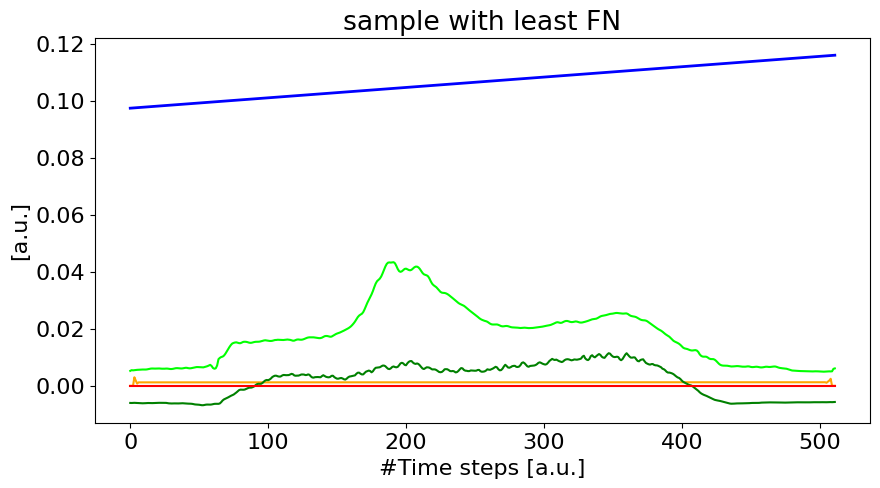

In [103]:
ind = 0

sample = test_ds[int(fn_sorted.iloc[ind]["index"])]
predictions_trans = metrics.loc[(metrics['index'] == int(fn_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == int(fn_sorted.iloc[ind]["index"])) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == int(fn_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(range(len(sample["mask"])), sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with least FN")
# plt.legend()
plt.show()

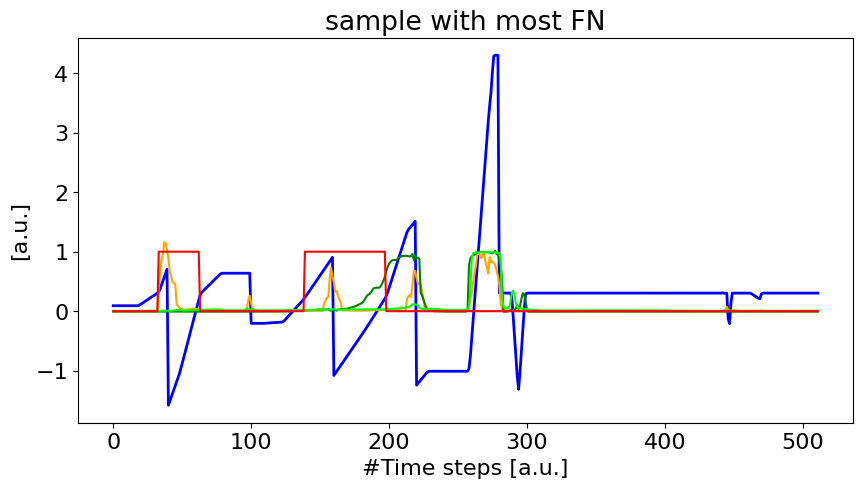

In [104]:
ind = -1

sample = test_ds[int(fn_sorted.iloc[ind]["index"])]
predictions_trans = metrics.loc[(metrics['index'] == int(fn_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN Trans.")]['prediction']
preds_transOnly_Lin = metrics.loc[(metrics['index'] == int(fn_sorted.iloc[ind]["index"])) & (metrics['detector'] == "Trans Only Lin")]['prediction']
predictions_conv = metrics.loc[(metrics['index'] == int(fn_sorted.iloc[ind]["index"])) & (metrics['detector'] == "FCN")]['prediction']

plt.figure(figsize=(10, 5))
plt.plot(sample["data"], label="window without artifact", linewidth=2, color='blue')

plt.plot(predictions_conv.squeeze().numpy(), label="FCN", c="orange")
plt.plot(preds_transOnly_Lin.squeeze().numpy(), label="Trans.", c="green")
plt.plot(predictions_trans.squeeze().numpy(), label="FCN Trans.", c="lime")
plt.plot(range(len(sample["mask"])), sample["mask"], c="red", label="mask")
plt.rcParams.update({'font.size': 16})
plt.xlabel('#Time steps [a.u.]') 
plt.ylabel("[a.u.]")
plt.title(f"sample with most FN")
# plt.legend()
plt.show()

In [81]:
metrics_total = metrics.groupby('detector')[['fbeta_score', 'accuracy', 'precision', 'recall', 'mse']].mean()
conf_mat_values = metrics.groupby('detector')[['tn', 'fp', 'fn', 'tp']].sum()
metrics_total.round(3)

,fbeta_score,accuracy,precision,recall,mse
detector,,,,,
FCN,0.130316,0.971635,0.149556,0.115848,0.028365
FCN Trans.,0.114813,0.984555,0.132878,0.080163,0.015445
FCN dense,0.012267,0.942067,0.015385,0.011757,0.057933
Stoch. Baseline,0.057846,0.975616,0.171059,0.037762,0.024384
Trans Only GAP,0.086604,0.872972,0.099263,0.084557,0.127028
Trans Only Lin,0.116838,0.982647,0.132840,0.085444,0.017353
adaFCN Dense,0.014795,0.949970,0.020673,0.011569,0.050030
adaFCN Trans.,0.095408,0.981205,0.120523,0.066671,0.018795
adapted FCN,0.150742,0.983519,0.160060,0.145060,0.016481


In [83]:
df = ((conf_mat_values/(conf_mat_values.iloc[0].sum()))*100).round(1)
df[["tp", "fp", "fn", "tn"]]

,tp,fp,fn,tn
detector,,,,
FCN,0.9,1.7,1.1,96.3
FCN Trans.,0.7,0.2,1.3,97.8
FCN dense,0.1,3.8,1.9,94.1
Stoch. Baseline,0.1,0.5,1.9,97.5
Trans Only GAP,0.6,11.3,1.4,86.7
Trans Only Lin,0.7,0.4,1.3,97.6
adaFCN Dense,0.1,3.1,1.9,94.9
adaFCN Trans.,0.5,0.4,1.5,97.6
adapted FCN,1.1,0.8,0.9,97.2


In [ ]:
for index in stats_index_fp:
    sample = test_ds[index]

    example = sample["data"]
    stride  = 64
    window  = convolution_detector.window
    length  = len(example)

    example_data = torch.tensor(example)

    # store prediction for each window
    predictions_baseline = torch.zeros(((length - window) // stride + 1, length))
    predictions_conv = torch.zeros(((length - window) // stride + 1, length))
    predictions_trans = torch.zeros(((length - window) // stride + 1, length))

    # store number of times each mask was predicted
    masks = torch.zeros(length)
    for i, j in enumerate(range(0, length - window + 1, stride)):
        # slice out window
        s = example_data[j : j + window]
        # make prediction and insert into prediction
        predictions_baseline[i, j : j + window] = baseline_detector(s)
        predictions_conv[i, j : j + window] = convolution_detector(s.unsqueeze(0))
        predictions_trans[i, j : j + window] = transformer_detector(s.unsqueeze(0))

        # update count
        masks[j : j + window] += 1

    predictions_baseline = predictions_baseline.sum(axis=0) / masks
    predictions_conv = predictions_conv.sum(axis=0) / masks
    predictions_trans = predictions_trans.sum(axis=0) / masks
    # predictions_trans = np.where(predictions_trans.numpy() > threshold, 1, 0)

    plt.figure(figsize=(15, 10))
    plt.plot(sample["mask"].index, sample["data"], label="data", c="blue")
    plt.plot(sample["mask"].index, predictions_baseline, label="pred_baseline", c="orange")
    plt.plot(sample["mask"].index, predictions_conv, label="pred_cnn", c="green")
    plt.plot(sample["mask"].index, predictions_trans, label="pred_trans", c="purple")
    plt.plot(sample["mask"].index, sample["mask"], c="red", label="mask")
    #plt.title(f"Predictions of 3 models vs. ground truth in test set, sample {sample["start_index"]}")
    plt.legend()
    plt.show()